In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os;
import tensorflow as tf;
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
sns.set_style('whitegrid')

In [41]:
data = fetch_california_housing()
df = pd.DataFrame(data.data,columns=data.feature_names)
df['price'] = pd.Series(data.target)
print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [42]:
# First, we split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['price'],axis=1),
                                    df['price'],
                                    test_size=0.2,
                                    random_state=0
                                    )
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (16512, 8) (16512,) 
* Test set: (4128, 8) (4128,)


In [43]:
# Then, from the train set, we split a validation set. We set the validation set as 20% of the train set
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

* Train set: (13209, 8) (13209,)
* Validation set: (3303, 8) (3303,)
* Test set: (4128, 8) (4128,)


In [44]:
def pipeline_pre_processing():
    """
    Define data preparation pipeline
    """
    pipeline_base = Pipeline([

      ( "feat_scaling", StandardScaler() )

    ])
    return pipeline_base

In [45]:
pipeline = pipeline_pre_processing()
X_train = pipeline.fit_transform(X_train)
X_val= pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [46]:
def create_tf_model(n_features):

  model = Sequential()
  model.add(Dense(units=n_features, activation='relu', input_shape=(n_features,)))

  model.add(Dense(units=8,activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(units=4,activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(units=1))
  model.compile(loss='mse', optimizer='adam')

  return model

In [47]:
model = create_tf_model(n_features=X_train.shape[1])
model.summary()

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185 (740.00 B)

 Trainable params: 185 (740.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
import pydot
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='/workspaces/tut2/outputs/regression.png')


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [49]:

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [50]:
model.fit(x=X_train,
          y=y_train,
          epochs=100,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9570 - val_loss: 1.3685
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8529 - val_loss: 0.9222
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3239 - val_loss: 0.7005
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0761 - val_loss: 0.5732
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9397 - val_loss: 0.5057
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8621 - val_loss: 0.4952
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7634 - val_loss: 0.4908
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7706 - val_loss: 0.4741
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6807 - val_loss: 0.4506
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6536 - val_loss: 0.4558
Epoch 11/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6375 - val_loss: 0.4367
Epoch 12/100
413/413 ━━━━━━━━━━━━━━━━━━━━

In [51]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,2.838575,1.368507
1,1.722739,0.922162
2,1.281721,0.700473
3,1.034245,0.573206
4,0.911311,0.505675
...,...,...
64,0.523939,0.431093
65,0.531927,0.409289
66,0.528992,0.411397
67,0.531309,0.416292


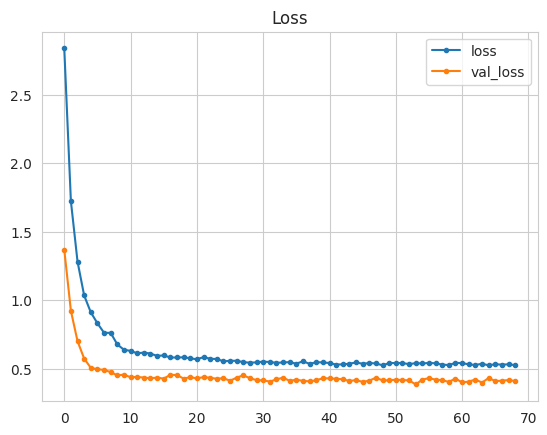

In [52]:

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.show()

In [53]:

model.evaluate(X_test,y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.4185


0.39813974499702454

In [54]:
def regression_performance(X_train, y_train,
                           X_val, y_val,
                           X_test, y_test,pipeline):
    """
    Assessment of performance of CNN regression model
    """
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Validation Set")
    regression_evaluation(X_val, y_val,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    - Predicts using the pipeline and the features
    - Calculates performance metrics comparing the prediction to the target
    """
    prediction = pipeline.predict(X)
    print('R2 Score:', round(r2_score(y, prediction), 3))
    print('Mean Absolute Error:', round(mean_absolute_error(y, prediction), 3))
    print('Mean Squared Error:', round(mean_squared_error(y, prediction), 3))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y, prediction)), 3))
    print("\n")
    

def regression_evaluation_plots(X_train, y_train,
                                X_val, y_val,
                                X_test, y_test,
                                pipeline, alpha_scatter=0.5):
    """
    Plot regression evaluation
    """
    pred_train = pipeline.predict(X_train).reshape(-1)
    # we reshape the prediction arrays to be in the format (n_rows,), so we can plot it after
    pred_val = pipeline.predict(X_val).reshape(-1)
    pred_test = pipeline.predict(X_test).reshape(-1)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
    
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_val , y=pred_val, alpha=alpha_scatter, ax=axes[1])
    
    sns.lineplot(x=y_val , y=y_val, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Validation Set")
    
    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[2])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[2])
    axes[2].set_xlabel("Actual")
    axes[2].set_ylabel("Predictions")
    axes[2].set_title("Test Set")
    
    plt.show()

Model Evaluation 

* Train Set
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
R2 Score: 0.701
Mean Absolute Error: 0.464
Mean Squared Error: 0.401
Root Mean Squared Error: 0.633


* Validation Set
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
R2 Score: 0.693
Mean Absolute Error: 0.467
Mean Squared Error: 0.409
Root Mean Squared Error: 0.64


* Test Set
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
R2 Score: 0.695
Mean Absolute Error: 0.466
Mean Squared Error: 0.398
Root Mean Squared Error: 0.631


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


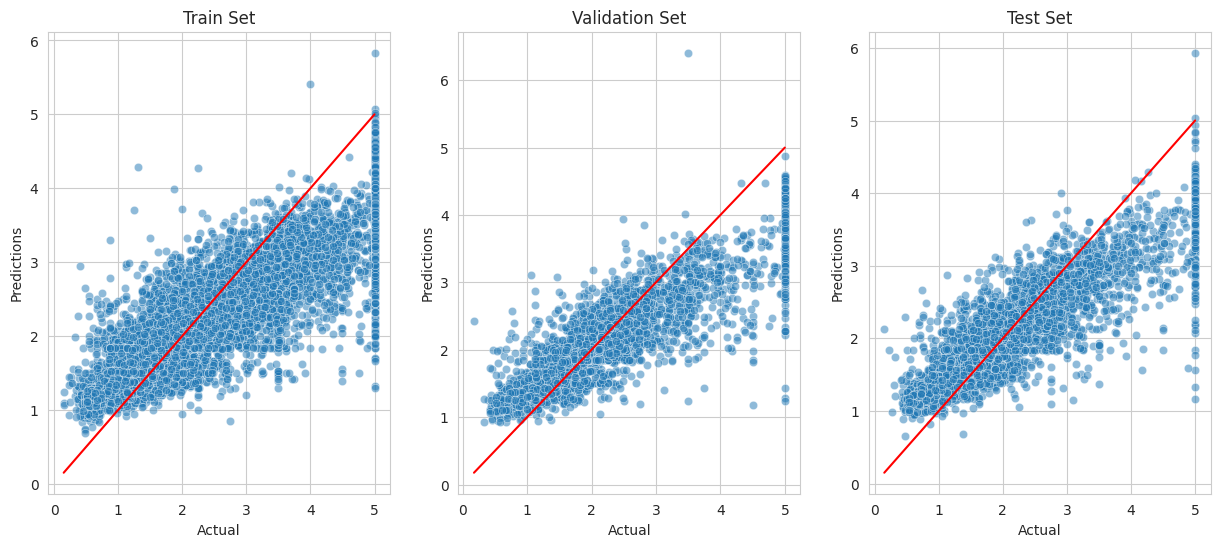

In [55]:

regression_performance(X_train, y_train,X_val, y_val, X_test, y_test,model)
regression_evaluation_plots(X_train, y_train, X_val, y_val,X_test, y_test,
                            model, alpha_scatter=0.5)

In [56]:
X_test.shape

(4128, 8)

In [57]:
live_data = X_test[54:55,:]
live_data

array([[-1.2449854 , -0.20116759, -1.69946574, -0.09213495, -0.2003886 ,
         0.14367436, -0.73320429,  0.64473104]])

In [58]:
model.predict(live_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[1.6046519]], dtype=float32)

In [59]:
sample = pd.DataFrame({
    'MedInc': [8.325200],
    'HouseAge': [41.000000],
    'AveRooms': [6.984127],
    'AveBedrms': [1.023810],
    'Population': [322.000000],
    'AveOccup': [2.555556],
    'Latitude': [37.880000],
    'Longitude': [-122.230000] 
})

sample

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23


In [60]:
sample_cnn = pipeline.transform(sample.values)
sample_cnn

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[ 2.33427752,  0.99158883,  0.69465782, -0.1578881 , -0.98629534,
        -0.08184656,  1.04783331, -1.3256435 ]])

In [61]:
predicted_price = model.predict(sample_cnn)[0][0]
print('---------------')
print(f"Predicted house price based on the information provided is: {predicted_price:.2f} arb. units.")
print('---------------')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
---------------
Predicted house price based on the information provided is: 3.52 arb. units.
---------------


In [62]:

model.save('../outputs/models/nn_regression.h5')